In [22]:
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd


# Mental Health Intervention Analysis: Young Adult Burnout
## **Data sources**

This notebook contains the analysis code used to generate the visualisations
for the DSA4262 assignment.

This analysis uses two datasets:

1. Global Burden of Disease (GBD) 2023
   - Source: Institute for Health Metrics and Evaluation (IHME)
   - URL: https://vizhub.healthdata.org/gbd-results/
   - Accessed: January 2026

2. Understanding Society (UK Household Longitudinal Study), 2023
   - Source: UK Data Service (SN: 6614)
   - Access requires registration and approval.
   - Variables used include GHQ-12, financial strain, and economic activity status.

Due to data access restrictions, raw datasets are not included in this repository.


### **Cleaning IHME GBD Data**

In [23]:
DATA_PATH = "data/gbd.csv"
df_gbd = pd.read_csv(DATA_PATH)
df_gbd['age_name'] = df_gbd['age_name'].str.replace('Years', '', case=False)
df_gbd['val'] = round(df_gbd['val']*100, 3) # convert to percentage
df_gbd['upper'] = round(df_gbd['upper']*100, 3) # convert to percentage
df_gbd['lower'] = round(df_gbd['lower']*100, 3) # convert to percentage   
df_gbd_clean = df_gbd[['year', 'age_id', 'age_name', 'val', 'upper', 'lower']]
df_gbd_clean = df_gbd_clean.sort_values(by=['year', 'age_name'])
df_gbd_clean_2023 = df_gbd_clean[df_gbd_clean['year'] == 2023]
df_gbd_clean_2023

FileNotFoundError: [Errno 2] No such file or directory: 'data/gbd.csv'

### **Plot 1**

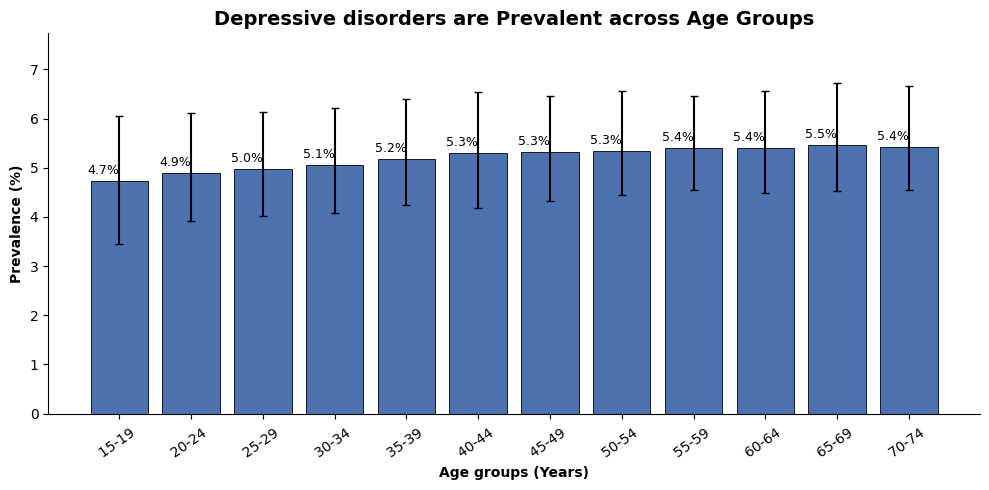

In [21]:
plot_df = df_gbd_clean_2023.sort_values("age_id")

### BUILD BAR CHART ###
x = plot_df["age_name"]
y = plot_df["val"]
yerr = [y - plot_df["lower"], plot_df["upper"] - y]  # asymmetric CI

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(
    x, y,
    yerr=yerr,
    capsize=3,
    color="#4C72B0",
    edgecolor="black",
    linewidth=0.6
)
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="right",
        va="bottom",
        fontsize=9
    )
### FORMATTING ###
ax.set_title("Depressive disorders are Prevalent across Age Groups", font = "sans", weight="bold", size=14)
ax.set_xlabel("Age groups (Years)", fontweight='bold')
ax.set_ylabel("Prevalence (%)", fontweight='bold')
ax.set_ylim(0, max(plot_df["upper"]) * 1.15)
ax.tick_params(axis="x", rotation=35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

plt.show()

### **Cleaning Understanding Society Data**

In [ ]:
DATA_PATH2 = "data/understanding_society.tab"
df_ukda = pd.read_csv(DATA_PATH2, sep="\t", low_memory=False)

### DEFINING CONSTANTS AND VARIABLES ###
COL_OUTCOME = "mno_scghq1_dv"   # GHQ Likert score (continuous)
COL_AGE     = "mno_age_dv"
COL_SEX     = "mno_sex_dv"          # usually 1=male, 2=female

#### FILTERING OUT THE AGE RANGE TO OBSERVE YOUTH MENTAL HEALTH ###
youth = df_ukda.copy()
youth = youth[(youth[COL_AGE] >= 18) & (youth[COL_AGE] <= 34)]
youth = youth.replace({-9: np.nan, -8: np.nan, -7: np.nan, -1: np.nan})  # replacing missing codes with NaN 
#    Value = -9.0	Label = missing
#	Value = -8.0	Label = inapplicable
#	Value = -7.0	Label = proxy
#	Value = -2.0	Label = refusal
#	Value = -1.0	Label = don't know

#youth = youth.dropna(subset=[COL_OUTCOME])

### CATEGORISING FINANCIAL STRAIN ###

strain_map = {
    1: "Low",
    2: "Low",
    3: "Moderate",
    4: "High",
    5: "High"
}

youth["fin_strain_grp"] = youth["mno_finnow"].map(strain_map)

order = ["Low", "Moderate", "High"]

data = [
    youth.loc[youth["fin_strain_grp"] == g, "mno_scghq1_dv"].dropna().values
    for g in order
]

### **Plot 2**

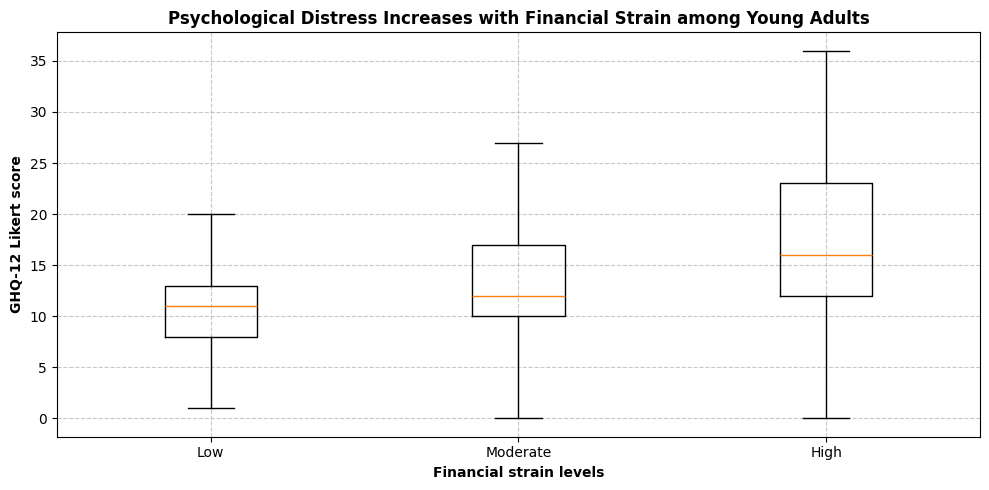

In [15]:
### PLOTTING BOXPLOT ###
plt.figure(figsize=(10, 5))
plt.boxplot(data, showfliers=False)
plt.xticks(
    ticks=range(1, len(order) + 1),
    labels=order,
    ha="center"
)
plt.ylabel("GHQ-12 Likert score", fontweight='bold')
plt.xlabel("Financial strain levels", fontweight='bold')
plt.title("Psychological Distress Increases with Financial Strain among Young Adults", fontweight='bold', size=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

### **Plot 3**

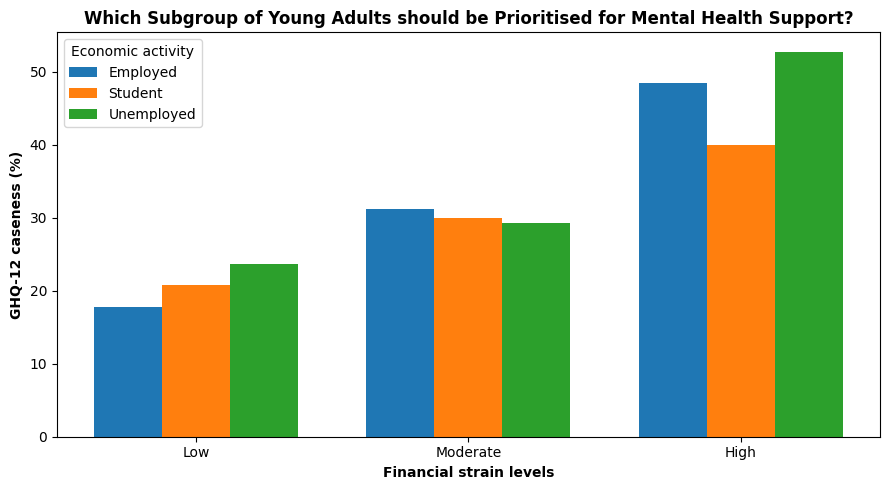

In [19]:
### CATEGORISING ECONOMIC ACTIVITY AND PLOTTING BAR CHART ###
def recode_activity(x):
    if x in [7]:  # Full-time student
        return "Student"
    elif x in [1, 2, 11]:  # Self-employed, paid employment, apprenticeship
        return "Employed"
    elif x in [3, 12, 13]:  # Unemployed, furlough, laid off
        return "Unemployed"
    else:
        return None  # drop others (retired, caregiving, etc.)

youth["activity_grp"] = youth["mno_jbstat"].apply(recode_activity)
youth["ghq_case"] = (youth["mno_scghq2_dv"] >= 4).astype(int) # Create a column for GHQ caseness which filters at threshold of 4
order = ["Low", "Moderate", "High"]

youth["fin_strain_grp"] = pd.Categorical(
    youth["fin_strain_grp"],
    categories=order,
    ordered=True
)

plot_df = (
    youth
    .dropna(subset=["fin_strain_grp", "activity_grp"])
    .groupby(["fin_strain_grp", "activity_grp"], observed=True)["ghq_case"]
    .mean()
    .reset_index()
) # Creating a dataframe for plotting the proportion of GHQ caseness by financial strain group and economic activity status

plot_df["ghq_case_pct"] = plot_df["ghq_case"] * 100 # Converting to percentage
plot_df = plot_df.sort_values("fin_strain_grp")

fig, ax = plt.subplots(figsize=(9,5))

groups = ["Employed", "Student", "Unemployed"]
x = np.arange(len(order))
width = 0.25

for i, grp in enumerate(groups):
    subset = plot_df[plot_df["activity_grp"] == grp]
    ax.bar(
        x + i * width,
        subset["ghq_case_pct"],
        width=width,
        label=grp
    )

ax.set_xticks(x + width)
ax.set_xticklabels(order)
ax.set_ylabel("GHQ-12 caseness (%)", fontweight='bold')
ax.set_xlabel("Financial strain levels", fontweight='bold')
ax.set_title(
    "Which Subgroup of Young Adults should be Prioritised for Mental Health Support?",
    fontweight='bold'
)
ax.legend(title="Economic activity")

plt.tight_layout()
plt.show()
